In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig
from joblib import Parallel
from joblib import delayed as jb_delayed

In [2]:
# Discretisation of Derivatives and Utility for Eigenvalue Problem. Derivatives are written such that (d^n f)/dx^n = Dn @ f in python syntax, where f is a 1D input array. Boundary conditions are no-slip on both sides of the domain. 

def M(x):
    
    '''builds matrix with entries on the diagonal being equal to the value of the 1D input function x'''
    
    n = len(x)
    M = np.zeros([n, n])
    for i in range(n):
        M[i,i] = x[i]
        
    return M

def D1(n, dx):
    ''' gives back first derivative matrix for vector of n points '''
    
    Der = np.zeros([n, n])
    
    # interior
    for i in range(2,n-2):
        Der[i,i-2] = 1
        Der[i,i-1] = -8
        Der[i,i+1] = 8
        Der[i,i+2] = -1
    
    # multiply delta
    Der = Der/(12*dx)
    
    # boundaries
    Der[1, 3] = -15/(210*dx)
    Der[1, 2] = 126/(210*dx)
    Der[1, 1] = 35/(210*dx)
    Der[1, 0] = -210/(210*dx)
    
    Der[0, 2] = -9/(450*dx)
    Der[0, 1] = 100/(450*dx)
    Der[0, 0] = 1125/(450*dx)
    
    Der[-2, -1] = 210/(210*dx)
    Der[-2, -2] = -35/(210*dx)
    Der[-2, -3] = -126/(210*dx)
    Der[-2, -4] = 15/(210*dx)    
    
    Der[-1, -1] = -1125/(450*dx)
    Der[-1, -2] = -100/(450*dx)
    Der[-1, -3] = 9/(450*dx)
    
    return Der
    
def D2(n, dx):
    ''' gives back second derivative matrix for vector of n points '''
    
    Der = np.zeros([n, n])
    
    # interior
    for i in range(2,n-2):
        Der[i,i-2] = -1
        Der[i,i-1] = 16
        Der[i,i] = -30
        Der[i,i+1] = 16
        Der[i,i+2] = -1
    
    # multiply delta
    Der = Der/(12*dx**2)
    
    # boundaries
    Der[1, 3] = -10/(105*dx**2)
    Der[1, 2] = 147/(105*dx**2)
    Der[1, 1] = -280/(105*dx**2)
    Der[1, 0] = 175/(105*dx**2)
    
    Der[0, 2] = -27/(225*dx**2)
    Der[0, 1] = 350/(225*dx**2)
    Der[0, 0] = -675/(225*dx**2)
    
    Der[-2, -1] = 175/(105*dx**2)
    Der[-2, -2] = -280/(105*dx**2)
    Der[-2, -3] = 147/(105*dx**2)
    Der[-2, -4] = -10/(105*dx**2)    
    
    Der[-1, -1] = -675/(225*dx**2)
    Der[-1, -2] = 350/(225*dx**2)
    Der[-1, -3] = -27/(225*dx**2)
    
    return Der

def D4(n, dx):
    ''' given back fourth derivative matrix for vector of n points '''
    
    Der = np.zeros([n, n])
    
    # interior
    for i in range(2,n-2):
        Der[i,i-2] = 1
        Der[i,i-1] = -4
        Der[i,i] = 6
        Der[i,i+1] = -4
        Der[i,i+2] = 1
    
    # multiply delta
    Der = Der/(dx**4)
    
    # boundaries
    Der[1, 3] = 40/(35*dx**4)
    Der[1, 2] = -168/(35*dx**4)
    Der[1, 1] = 280/(35*dx**4)
    Der[1, 0] = -280/(35*dx**4)
    
    Der[0, 2] = 144/(75*dx**4)
    Der[0, 1] = -800/(75*dx**4)
    Der[0, 0] = 3600/(75*dx**4)
    
    Der[-2, -1] = -280/(35*dx**4)
    Der[-2, -2] = 280/(35*dx**4)
    Der[-2, -3] = -168/(35*dx**4)
    Der[-2, -4] = 40/(35*dx**4)    
    
    Der[-1, -1] = 3600/(75*dx**4)
    Der[-1, -2] = -800/(75*dx**4)
    Der[-1, -3] = 144/(75*dx**4)
    
    return Der

In [3]:
def instability(xi, delta, l, delta_I, delta_P, nu):
    
    '''  calculates most unstable mode for a 2-layer inertial western boundary current. l is the meridional wave number.'''

    L  = 10 # always calculate ten inertial layer widths.
    N = int(np.ceil(L/(delta_P))) # have at least one point in the prandtl sublayer
    
    dx = L/N #delta
    x = np.linspace(dx/2, L-dx/2, N)
    
    #define base profile (equation 6 in main text)
    V = np.exp(-x)  - np.exp(-(x)/delta_P)
    D2V =  np.exp(-x)  - np.exp(-x/delta_P)/delta_P**2 # second x-derivative
    
    # build matrices for coupled two-layer instability problem
    A = np.zeros((2*N,2*N),dtype=np.complex_)
    B = np.zeros((2*N,2*N),dtype=np.complex_)
    
    I = M(np.ones(N))
    
    # Left-hand side of modal evolution equation
    A[:N,:N] = D2(N, dx) - (l**2 + xi*(1-delta))*I
    A[:N,N:] = xi*(1-delta)*I
    A[N:,:N] = xi*delta*I
    A[N:,N:] = D2(N,dx) - (l**2 + xi*delta)*I
    
    # righ-hand side
    B[:N,:N] = -l*M(D2V) + l*M(V)@(D2(N,dx) - l**2*I) - 1j/4*delta_I*D1(N,dx) + 1j*nu*(D4(N,dx) - 2*l**2*D2(N,dx) + l**4*I)
    B[:N,N:] =  xi*(1-delta)*l*M(V)
    B[N:,N:] = -xi*delta*l*M(V) - 1j/4*delta_I*D1(N,dx) + 1j*nu*(D4(N,dx) - 2*l**2*D2(N,dx) + l**4*I)
    
    # calculate eigenvalue problem
    out = eig(B, A)
    imags = out[0].imag

    index = np.where(imags == np.max(imags))[0][0]
    eig_funcs = out[1]
    eig_func = eig_funcs[:,index]
     
    eig_values = out[0]
    eig_value = eig_values[index]
        
    return eig_value, eig_func

In [6]:
# instability calculation parameters

nu_d = 10 # dimensional viscosity
Lx = 4000e3 # size of the basin (for layer width calculations only)
beta = 1.7e-11
tau0 = 1e-5
h1 = 40

# dimensional sverdrup variables
delta_I_d = np.sqrt(8*np.pi*tau0/(h1*beta**2*Lx)) # dimensional inertial layer width
delta_I = delta_I_d/Lx
U_I_d = 2*np.pi*tau0/(h1*beta)/delta_I_d # dimensional inertial layer velocity
delta_P_d = np.sqrt(nu_d/(U_I_d*Lx/4))*Lx/4 # dimensional viscous sublayer width

# nondimensional widths (we non-dimensionalize with the inertial layer width and velocity).
delta_P = delta_P_d/delta_I_d
nu = nu_d/(U_I_d*delta_I_d)

N_l = 10 # number of ls to test
N_xi = 50 # number of xis to test

delta_eq = 0 # the case delta = 0 is exactly equivalent to the 1.5-layer case, compare with equations (1), (2) in main text
delta = 0.01

# create parameter space to test
l_range = np.logspace(-1, 1, N_l)  
xis = np.logspace(-2, 2, N_xi)

Growth_rate = np.zeros([N_xi])
Growth_rate_equivalent = np.zeros([N_xi])

In [7]:
# calculate 1.5-layer growth rates

for j, xi in enumerate(xis):

    print(j)
    res = Parallel(n_jobs=N_l,backend='multiprocessing')(jb_delayed(instability)(xi, delta_eq, l_range[i], delta_I, delta_P, nu) for i in range(N_l))

    eig_vals = np.zeros(N_l, dtype = complex)
    for k in range(N_l):
        eig_vals[k] = res[k][0]
    
    index = np.where(eig_vals.imag == np.max(eig_vals.imag))[0][0]
    
    Growth_rate_equivalent[j] = eig_vals[index].imag

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
# calculates baroclinic growth rates

for j, xi in enumerate(xis):

    print(j)
    res = Parallel(n_jobs=N_l,backend='multiprocessing')(jb_delayed(instability)(xi, delta, l_range[i], delta_I, delta_P, nu) for i in range(N_l))

    eig_vals = np.zeros(N_l, dtype = complex)
    for k in range(N_l):
        eig_vals[k] = res[k][0]
    
    index = np.where(eig_vals.imag == np.max(eig_vals.imag))[0][0]
    
    Growth_rate[j] = eig_vals[index].imag

In [9]:
def draw_base_profile(axes, delta_P, Size = 15):

    # function to create base profile plot
    
    N_delta = 3 # plot width in inertial boundary layer units
    N = 200
    
    x = np.linspace(0, N_delta, N)
    
    V = np.exp(-x) - np.exp(-x/delta_P)
    axes.plot(x, V, "k-")
    axes.plot(np.ones(N)*delta_P, np.linspace(0,1,N), linestyle = "dashed", c = 'k', label = r"$x = \delta_P$")
    axes.plot(np.ones(N), np.linspace(0,1,N), linestyle = "-.", c = 'k', label = r"$x = \delta_I$")
    axes.set_ylim([0,1])
    axes.legend()
    axes.set_xticks([0,1,2,3],["0","1","2","3"])
    axes.set_yticks([0,0.5,1],["0","0.5", "1"])
    axes.set_xlim([0,N_delta])
    #axes.grid()
    axes.set_aspect(N_delta)
    axes.set_xlabel(r"$\frac{x}{\delta_I}$", size = Size+3)
    axes.set_ylabel(r"$\frac{v}{U_I}$", rotation = 0, size = Size + 3)
    axes.yaxis.set_label_coords(-0.2,0.4)

In [ ]:
import matplotlib
from matplotlib.gridspec import GridSpec

plt.rcParams['font.family'] = 'serif'

fig = plt.figure(layout="tight", figsize = (9,3.5))
Size = 13
gs = GridSpec(1, 2, figure=fig)

# draw base profile
axes = fig.add_subplot(gs[0, 0])
draw_base_profile(axes, delta_P, Size = Size)

# draw growth rates
axes = fig.add_subplot(gs[0, 1])

# plot
axes.plot(xis, Growth_rate_equivalent/delta_I**2, label = "1.5-layer", linewidth = 5, color = "black") # the factor 1/delta_I^2 rescales the growth rate with respect to the gyre turnover time L/U_Sv
axes.plot(xis, Growth_rate/delta_I**2, label = r"2-layer ($\delta = 0.01$)", linewidth = 2, color = "lightgray")

# axes format
axes.set_xscale("log")
axes.set_yscale("log")
axes.set_ylim([1e0, 1e3])
axes.set_xlim([1e-1, 1e3])
axes.set_xlabel(r"$\xi$", size = Size)
axes.set_ylabel(r"$\frac{\sigma^{max}_{inst}}{\sigma_{Gyre}}$", rotation = 0, size = Size+3)
axes.legend()
axes.grid()
axes.set_aspect(4/3)
axes.yaxis.set_label_coords(-0.2,0.4)

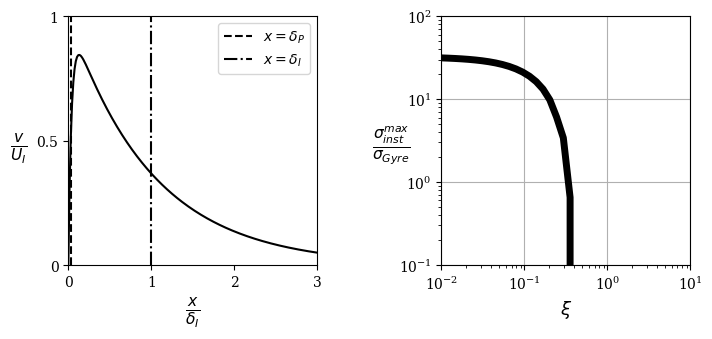

In [15]:
import matplotlib
from matplotlib.gridspec import GridSpec

plt.rcParams['font.family'] = 'serif'

fig = plt.figure(layout="tight", figsize = (9,3.5))
Size = 13
gs = GridSpec(1, 2, figure=fig)

# draw base profile
axes = fig.add_subplot(gs[0, 0])
draw_base_profile(axes, delta_P, Size = Size)

# draw growth rates
axes = fig.add_subplot(gs[0, 1])

# plot
axes.plot(xis, Growth_rate_equivalent/delta_I**2, label = "1.5-layer", linewidth = 5, color = "black") # the factor 1/delta_I^2 rescales the growth rate with respect to the gyre turnover time L/U_Sv

# axes format
axes.set_xscale("log")
axes.set_yscale("log")
axes.set_ylim([1e-1, 1e2])
axes.set_xlim([1e-2, 1e1])
axes.set_xlabel(r"$\xi$", size = Size)
axes.set_ylabel(r"$\frac{\sigma^{max}_{inst}}{\sigma_{Gyre}}$", rotation = 0, size = Size+3)
#axes.legend()
axes.grid()
axes.set_aspect(3/3)
axes.yaxis.set_label_coords(-0.2,0.4)